In [1]:
import os
import cv2
import numpy as np
from scipy import ndimage as nd
import pandas as pd
import pickle
from skimage.filters import sobel
from skimage import feature
from matplotlib import pyplot as plt
from sklearn import metrics

In [2]:
X = list()
Y = list()

read_directory = "0.0.Normal_CLAHE"

for file in os.listdir(read_directory):
    f_read = os.path.join(read_directory, file)
    
    img = cv2.imread(f_read, 0)
    sobel_img = sobel(img)
    flat_img = img.flatten()
    sobel_flat_img = sobel_img.flatten()
    flat_img = np.append(flat_img, sobel_flat_img)
    X.append(flat_img)
    Y.append(0)    # Normal: 0

read_directory = "Glaucoma_CLAHE\Glaucoma_Positive"

for file in os.listdir(read_directory):
    f_read = os.path.join(read_directory, file)
    
    img = cv2.imread(f_read, 0)
    sobel_img = sobel(img)
    flat_img = img.flatten()
    sobel_flat_img = sobel_img.flatten()
    flat_img = np.append(flat_img, sobel_flat_img)
    X.append(flat_img)
    Y.append(1)    # Glaucoma Positive: 1
    
read_directory = "DR_CLAHE\DR_Positive"

for file in os.listdir(read_directory):
    f_read = os.path.join(read_directory, file)
    
    img = cv2.imread(f_read, 0)
    sobel_img = sobel(img)
    flat_img = img.flatten()
    sobel_flat_img = sobel_img.flatten()
    flat_img = np.append(flat_img, sobel_flat_img)
    X.append(flat_img)
    Y.append(2)    # DR Positive: 2

X = np.array(X)
Y = np.array(Y)

In [3]:
print(X.shape)

(374, 100352)


In [4]:
print('Total:', len(Y))

print(np.bincount(Y))

Total: 374
[ 38 168 168]


In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X, Y = shuffle(X, Y, random_state = 10)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 10)

In [15]:
from sklearn import linear_model

model_LR = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)

model_LR.fit(X_train, y_train)

# save the model to disk
filename = 'model_LR.sav'
pickle.dump(model_LR, open(filename, 'wb'))

predictions_LR = model_LR.predict(X_test)

print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, predictions_LR))

Logistic Regression Accuracy: 0.9823008849557522


In [16]:
from sklearn import svm

model_SVM = svm.SVC(decision_function_shape='ovo')
# model_SVM = svm.LinearSVC()

model_SVM.fit(X_train, y_train)

# save the model to disk
filename = 'model_SVM.sav'
pickle.dump(model_SVM, open(filename, 'wb'))

predictions_SVM = model_SVM.predict(X_test)

print("SVM (one vs one) Accuracy:", metrics.accuracy_score(y_test, predictions_SVM))

SVM (one vs one) Accuracy: 0.9292035398230089


In [17]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier()

model_RF.fit(X_train, y_train.ravel())

# save the model to disk
filename = 'model_RF.sav'
pickle.dump(model_RF, open(filename, 'wb'))

predictions_RF = model_RF.predict(X_test)

print("Random Forest Accuracy:", metrics.accuracy_score(y_test, predictions_RF))

Random Forest Accuracy: 0.9911504424778761


Confusion matrix, without normalization
[[18  0  0]
 [ 0 49  0]
 [ 0  1 45]]


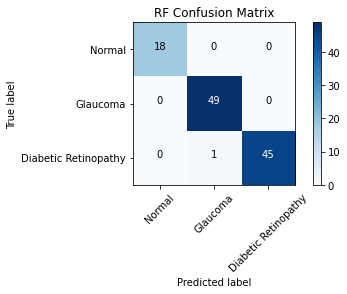

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score
import itertools

cm = confusion_matrix(y_true = y_test.flatten(), y_pred=predictions_RF)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm_plot_labels = ['Normal', 'Glaucoma', 'Diabetic Retinopathy']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='RF Confusion Matrix')

Confusion matrix, without normalization
[[18  0  0]
 [ 0 48  1]
 [ 0  7 39]]


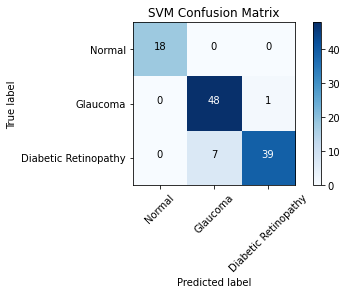

In [13]:
cm = confusion_matrix(y_true = y_test, y_pred=predictions_SVM)

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='SVM Confusion Matrix')

Confusion matrix, without normalization
[[18  0  0]
 [ 0 49  0]
 [ 1  1 44]]


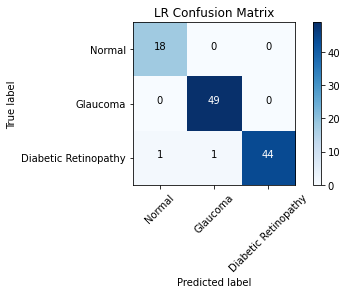

In [14]:
cm = confusion_matrix(y_true = y_test, y_pred=predictions_LR)

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='LR Confusion Matrix')

In [18]:
print('RF F1 score: ', f1_score(y_test, predictions_RF, average='macro'))

print('SVM F1 score: ', f1_score(y_test, predictions_SVM, average='macro'))

print('LR F1 score: ', f1_score(y_test, predictions_LR, average='macro'))

RF F1 score:  0.992969992969993
SVM F1 score:  0.9433512224209899
LR F1 score:  0.9802165802165802
